# Generate the time series of TN

In [1]:
import numpy as np

# Seed for reproducibility
np.random.seed(42)

def generate_TN_time_series(duration=40000, on_time=2000, off_time=5000, on_amp=1, off_amp=-1, perturbation=True):
    """
    Generate a TN time series with specified parameters and optional perturbations.

    Parameters:
    - duration: Total duration of the time series in years.
    - on_time, off_time: Duration of the on and off states in years.
    - on_amp, off_amp: Amplitudes for the on and off states.
    - perturbation: Whether to apply random perturbations to the amplitudes and durations.

    Returns:
    - A numpy array representing the TN time series.
    """
    time_series = []
    time = 0
    np.random.seed(42)

    while time < duration:
        # Apply random perturbations
        current_on_time = on_time + np.random.uniform(0, 1000) if perturbation else on_time
        current_off_time = off_time + np.random.uniform(0, 1000) if perturbation else off_time
        current_on_amp = on_amp + np.random.uniform(0, 0.3) if perturbation else on_amp
        current_off_amp = off_amp + np.random.uniform(0, 0.3) if perturbation else off_amp

        # Ensure the series does not exceed the specified duration
        if time + current_on_time <= duration:
            time_series.extend([current_on_amp] * int(current_on_time))
            time += current_on_time
        else:
            break

        if time + current_off_time <= duration:
            time_series.extend([current_off_amp] * int(current_off_time))
            time += current_off_time
        else:
            break

    return np.array(time_series)

# Generate the TN time series
tn_time_series = generate_TN_time_series()

# Display the first 100 data points to get a sense of the series
tn_time_series[:100]


array([1.21959818, 1.21959818, 1.21959818, 1.21959818, 1.21959818,
       1.21959818, 1.21959818, 1.21959818, 1.21959818, 1.21959818,
       1.21959818, 1.21959818, 1.21959818, 1.21959818, 1.21959818,
       1.21959818, 1.21959818, 1.21959818, 1.21959818, 1.21959818,
       1.21959818, 1.21959818, 1.21959818, 1.21959818, 1.21959818,
       1.21959818, 1.21959818, 1.21959818, 1.21959818, 1.21959818,
       1.21959818, 1.21959818, 1.21959818, 1.21959818, 1.21959818,
       1.21959818, 1.21959818, 1.21959818, 1.21959818, 1.21959818,
       1.21959818, 1.21959818, 1.21959818, 1.21959818, 1.21959818,
       1.21959818, 1.21959818, 1.21959818, 1.21959818, 1.21959818,
       1.21959818, 1.21959818, 1.21959818, 1.21959818, 1.21959818,
       1.21959818, 1.21959818, 1.21959818, 1.21959818, 1.21959818,
       1.21959818, 1.21959818, 1.21959818, 1.21959818, 1.21959818,
       1.21959818, 1.21959818, 1.21959818, 1.21959818, 1.21959818,
       1.21959818, 1.21959818, 1.21959818, 1.21959818, 1.21959

# Plot the TN

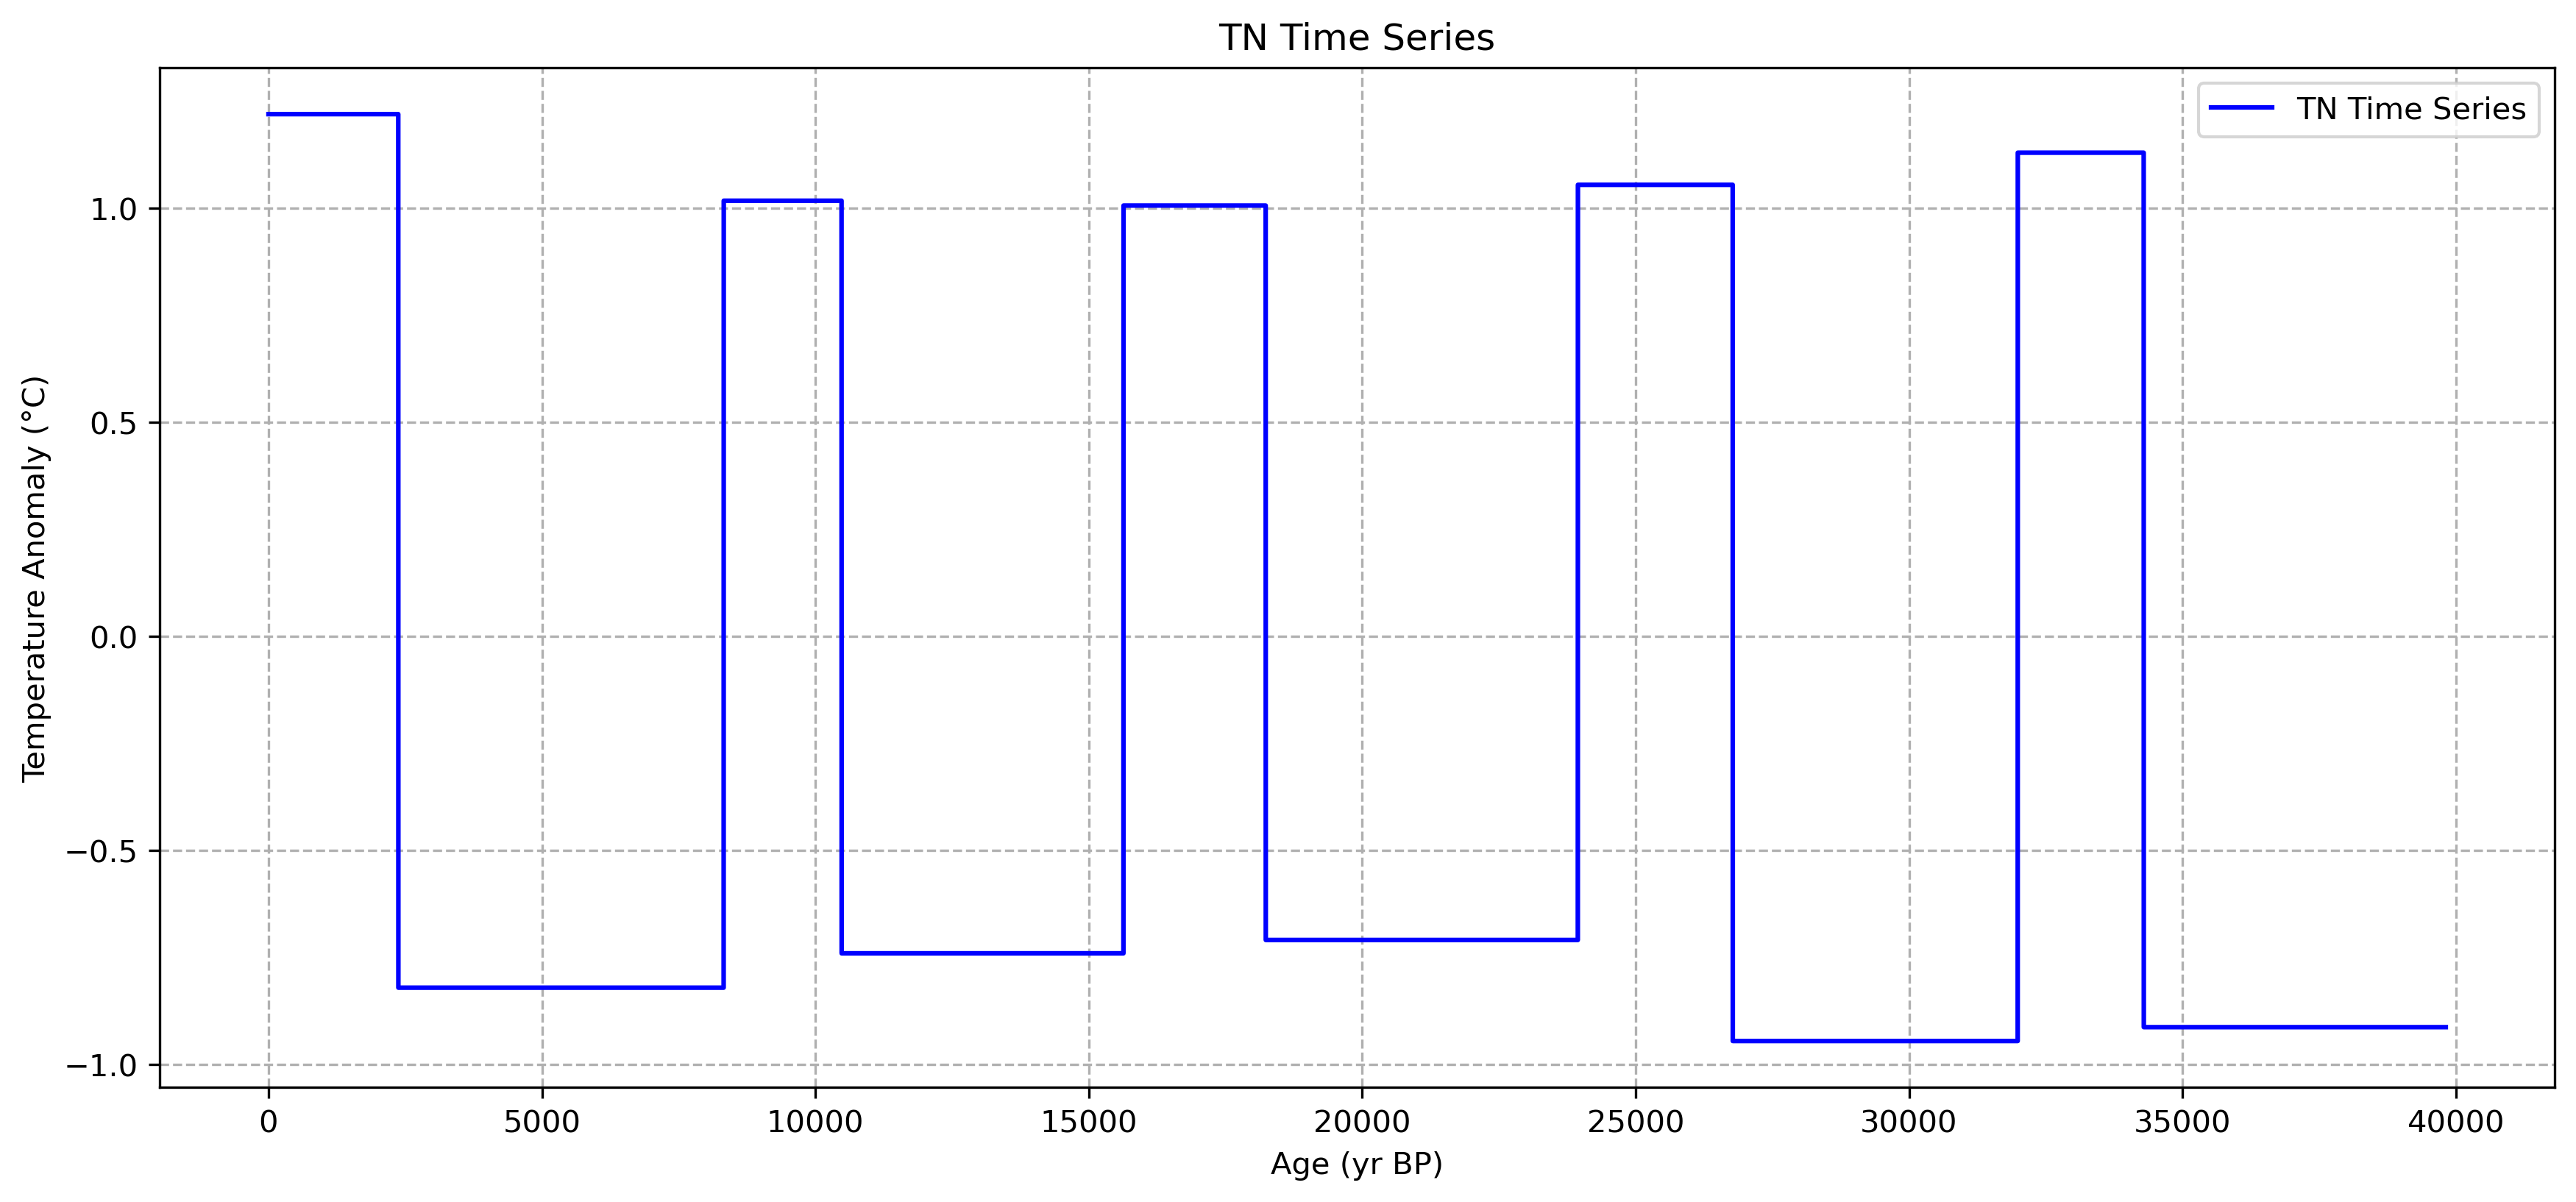

In [2]:
import matplotlib.pyplot as plt

# Plot the generated TN time series without using a function
plt.figure(figsize=(14, 6),dpi=300)
plt.plot(tn_time_series, label='TN Time Series', color='b')
plt.xlabel('Age (yr BP)')
plt.ylabel('Temperature Anomaly (°C)')
plt.title('TN Time Series')
# add grid with linestyle '--'
plt.grid(linestyle='--')
plt.legend()
plt.show()


# The model

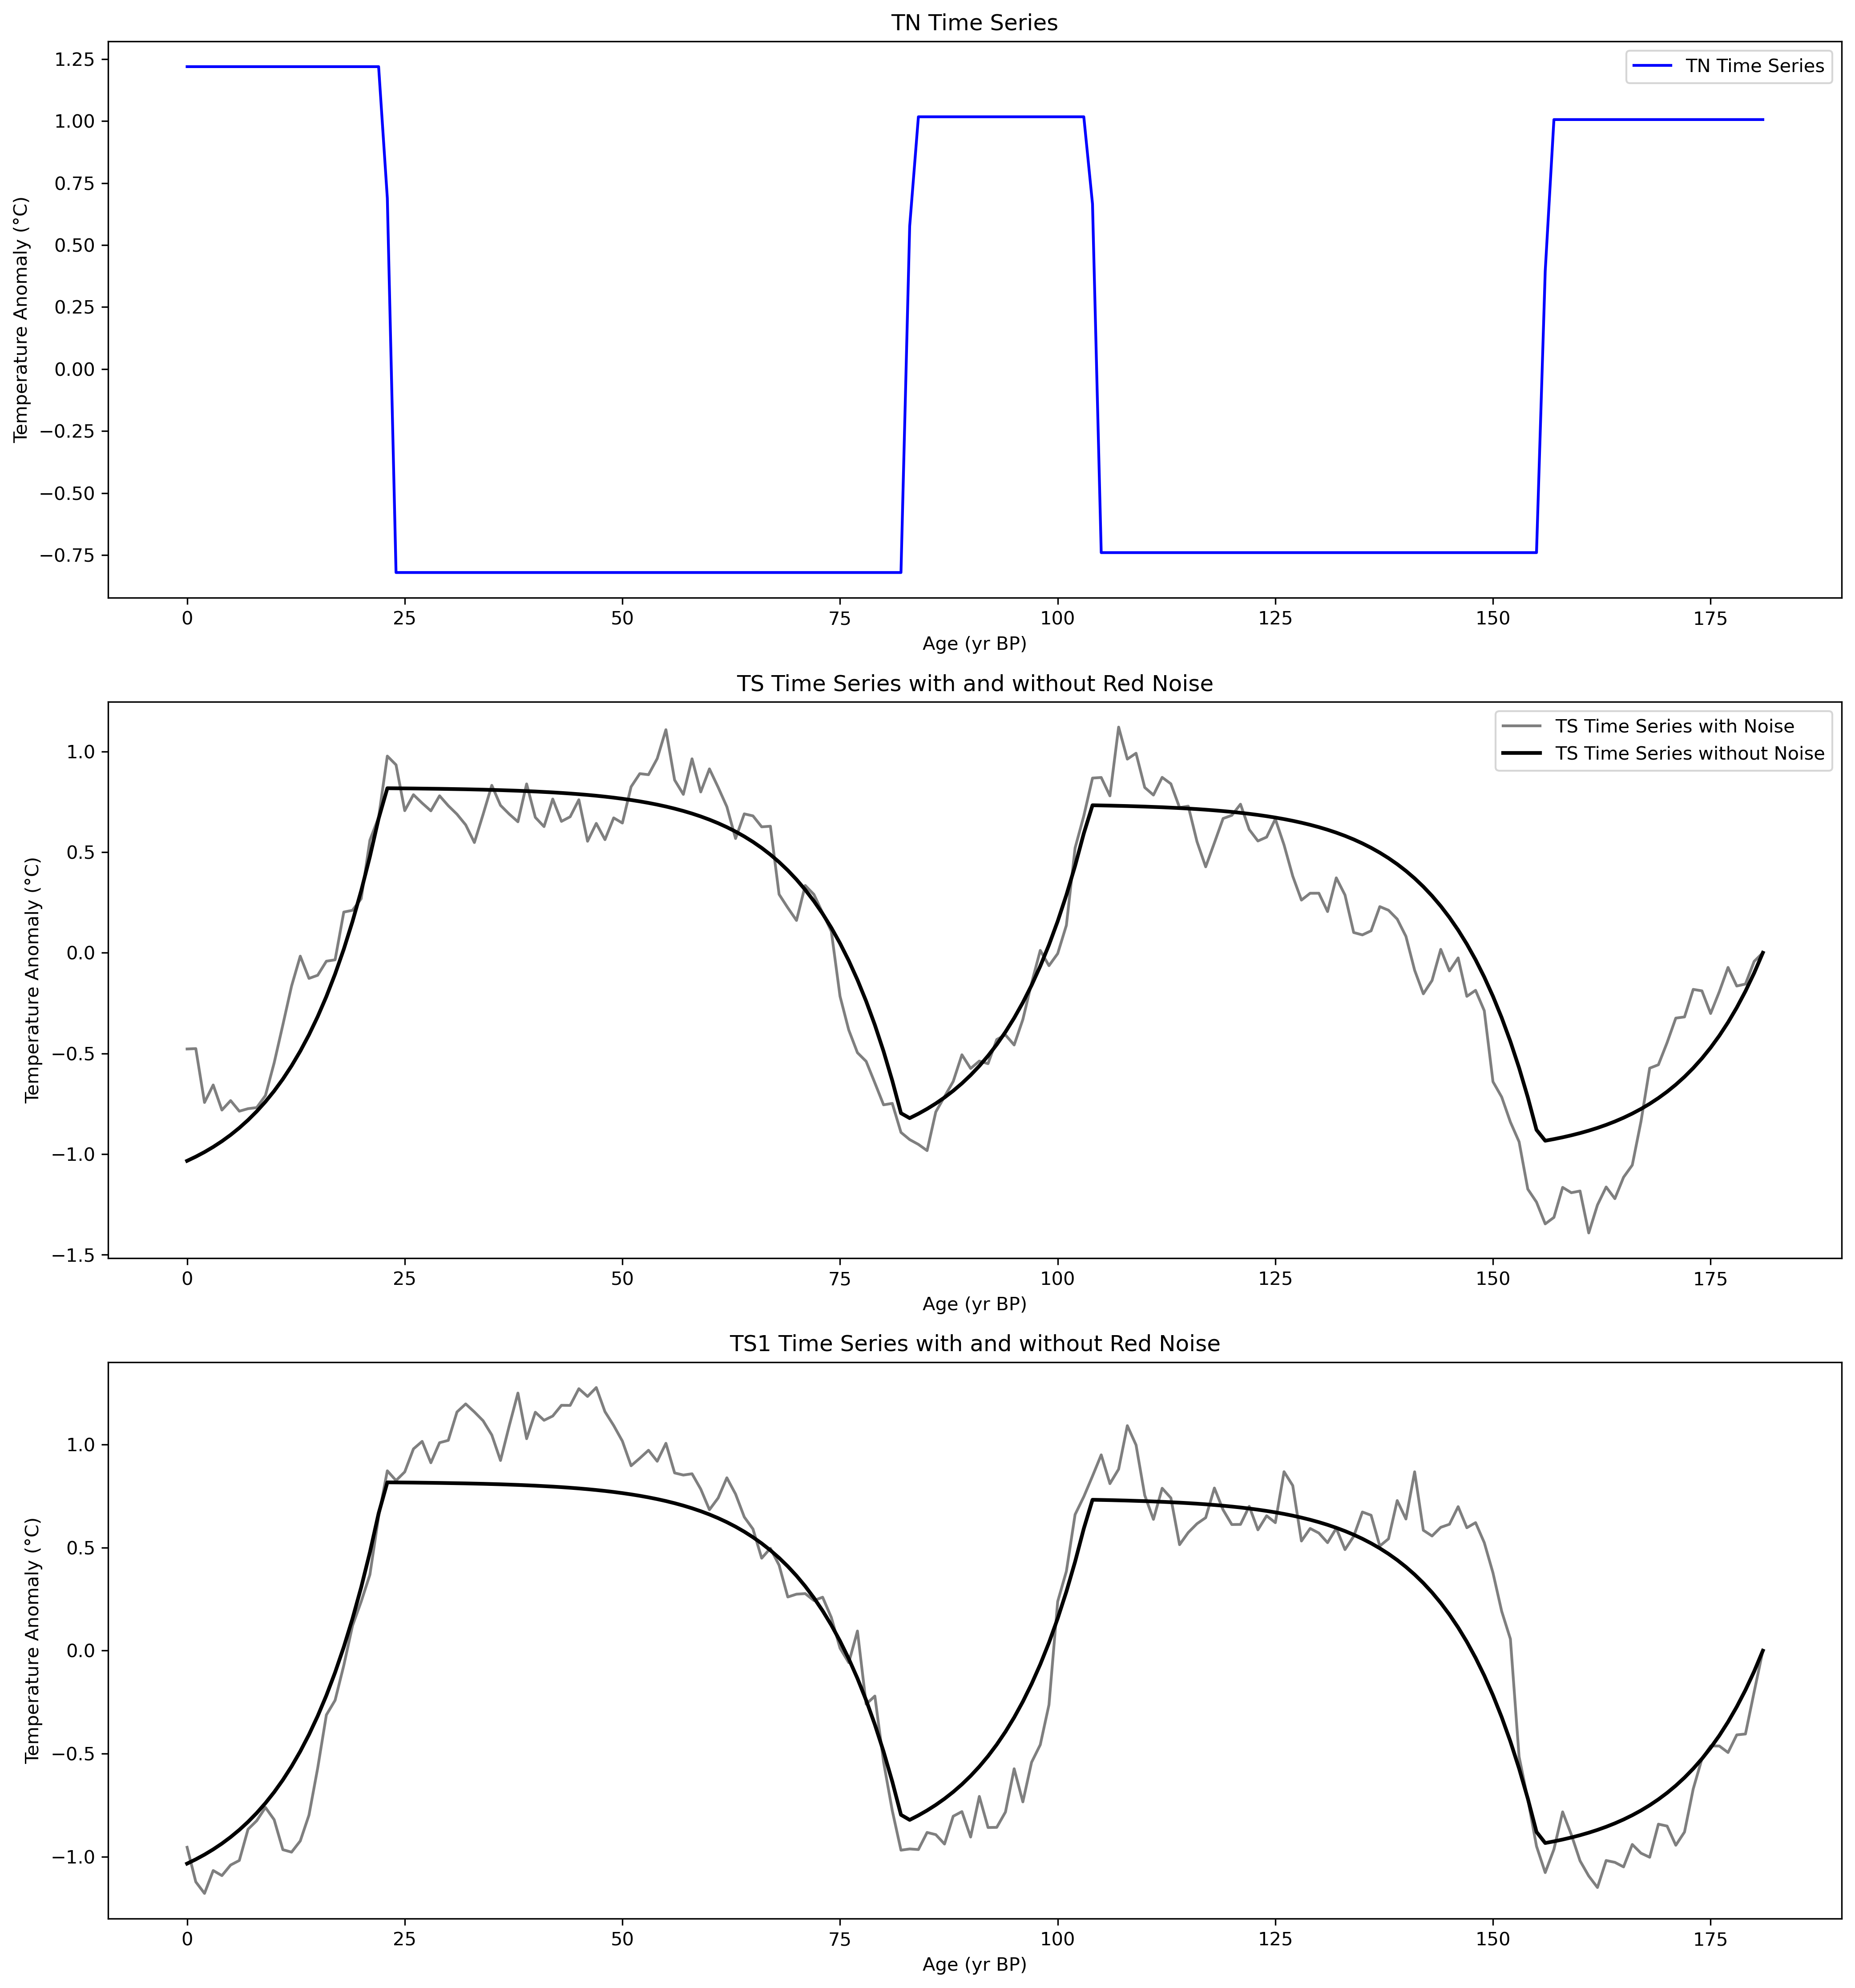

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Resample TN time series to match timestep dt of 10 years
def resample_TN(tn_series, dt=10):
    # Calculate the number of periods in the resampled series
    num_periods = len(tn_series) // dt
    # Resample by averaging over each dt period
    resampled_tn = np.array([np.mean(tn_series[i*dt:(i+1)*dt]) for i in range(num_periods)])
    return resampled_tn

# Parameters for the model
dt = 100  # Time step in years
tau = 1000  # Characteristic timescale in years
TS_initial = 0  # Initial condition for TS
a = 0.9  # Red noise parameter
std_dev = 0.01 # Standard deviation for the white noise component

# Generate and resample a shorter TN time series
tn_time_series_shortened = generate_TN_time_series(duration=20000)
tn_time_series_resampled = resample_TN(tn_time_series_shortened, dt)

# Calculate TS without noise, reversing the calculation direction
TS_without_noise_reversed = np.zeros(len(tn_time_series_resampled))
TS_without_noise_reversed[-1] = TS_initial

TS1_without_noise_reversed = np.zeros(len(tn_time_series_resampled))
TS1_without_noise_reversed[-1] = TS_initial

for i in range(len(tn_time_series_resampled) - 2, -1, -1):
    delta_TS = dt * (1/tau) * (-tn_time_series_resampled[i+1] - TS_without_noise_reversed[i+1])
    TS_without_noise_reversed[i] = TS_without_noise_reversed[i+1] + delta_TS

for i in range(len(tn_time_series_resampled) - 2, -1, -1):
    delta_TS = dt * (1/tau) * (-tn_time_series_resampled[i+1] - TS1_without_noise_reversed[i+1])
    TS1_without_noise_reversed[i] = TS1_without_noise_reversed[i+1] + delta_TS

# Adjust the standard deviation for red noise based on the variance of TS without noise
variance_TS_without_noise = np.var(TS_without_noise_reversed)
adjusted_std_dev = np.sqrt(variance_TS_without_noise / 30)

# adjusted_std_dev= std_dev

np.random.seed(42)
# Generate adjusted red noise
red_noise_reversed = np.zeros(len(tn_time_series_resampled))
for i in range(len(tn_time_series_resampled) - 2, -1, -1):
    epsilon_t = np.random.normal(0, adjusted_std_dev)
    red_noise_reversed[i] = a * red_noise_reversed[i+1] + epsilon_t

red_noise_reversed1 = np.zeros(len(tn_time_series_resampled))

for i in range(len(tn_time_series_resampled) - 2, -1, -1):
    epsilon_t = np.random.normal(0, adjusted_std_dev)
    red_noise_reversed1[i] = a * red_noise_reversed1[i+1] + epsilon_t

# Add adjusted red noise to TS without noise
TS_with_adjusted_noise_reversed = TS_without_noise_reversed + red_noise_reversed
TS1_with_adjusted_noise_reversed = TS1_without_noise_reversed + red_noise_reversed1

# adding white noise to TN
# tn_time_series_resampled=tn_time_series_resampled+np.random.normal(0, 0.2, len(tn_time_series_resampled))

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(14, 15),dpi=300)
axs[0].plot(tn_time_series_resampled, label='TN Time Series', color='blue')
axs[0].set_title('TN Time Series')
axs[0].set_xlabel('Age (yr BP)')
axs[0].set_ylabel('Temperature Anomaly (°C)')
axs[0].legend()

axs[1].plot(TS_with_adjusted_noise_reversed, label='TS Time Series with Noise', color='k', alpha=0.5,linestyle='-')
axs[1].plot(TS_without_noise_reversed, label='TS Time Series without Noise', color='k', linewidth=2, linestyle='-')
axs[1].set_title('TS Time Series with and without Red Noise')
axs[1].set_xlabel('Age (yr BP)')
axs[1].set_ylabel('Temperature Anomaly (°C)')
axs[1].legend()

axs[2].plot(TS1_with_adjusted_noise_reversed, label='TS Time Series with Noise', color='k', alpha=0.5,linestyle='-')
axs[2].plot(TS1_without_noise_reversed, label='TS Time Series without Noise', color='k', linewidth=2, linestyle='-')
axs[2].set_title('TS1 Time Series with and without Red Noise')
axs[2].set_xlabel('Age (yr BP)')
axs[2].set_ylabel('Temperature Anomaly (°C)')

plt.tight_layout()
plt.show()


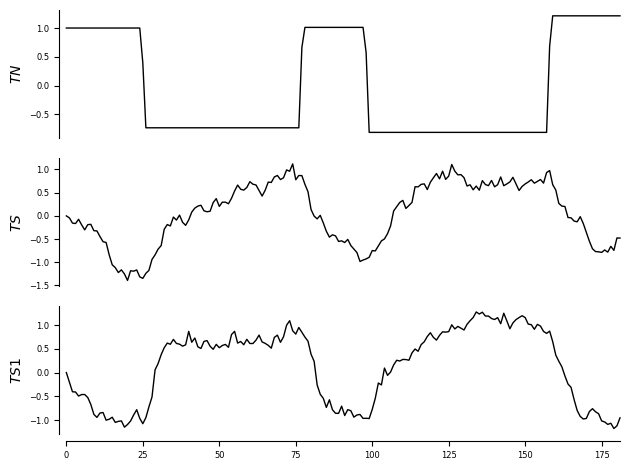

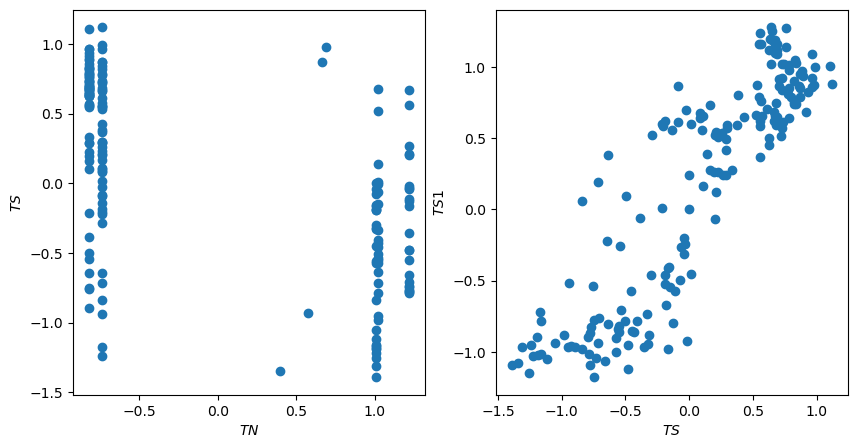

In [34]:
# reverse data
TN=tn_time_series_resampled[::-1]
TS=TS_with_adjusted_noise_reversed[::-1]
TS1=TS1_with_adjusted_noise_reversed[::-1]

import numpy as np
import matplotlib.pyplot as plt
import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import parcorr, gpdc, cmiknn
import pandas as pd



data = np.array([TN, TS, TS1]).T


var_names = [r'$TN$', r'$TS$', r'$TS1$']

dataframe = pp.DataFrame(data, var_names=var_names)
tp.plot_timeseries(dataframe); plt.show()


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(data[:, 0], data[:, 1])
plt.xlabel(var_names[0])
plt.ylabel(var_names[1])

plt.subplot(1, 2, 2)
plt.scatter(data[:, 1], data[:, 2])
plt.xlabel(var_names[1])
plt.ylabel(var_names[2])
plt.show()

# last run:82min

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_ve

(<Figure size 640x480 with 1 Axes>, <Axes: >)

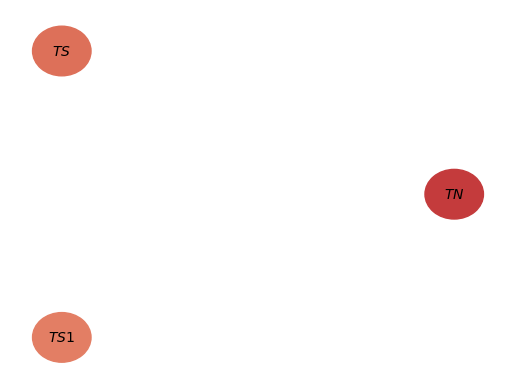

In [35]:
gpdc_test = gpdc.GPDC(significance='analytic', gp_params=None)
pcmci_gpdc = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=gpdc_test,
    verbosity=0)

results = pcmci_gpdc.run_pcmci(tau_max=2, pc_alpha=None, alpha_level = 0.01)
tp.plot_graph(
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=var_names,
    show_colorbar=False,
    )